In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

After importing our libraries, we read the CSV file containing information about solar power generated (MW) every 5 minutes for the whole year of 2006. We split the Date and Time information into new colums so we can later aggregate the total amount of power generated per day.

In [2]:
df = pd.read_csv('/Users/tareq/solar_panel_model/ny-pv-2006/Actual_40.85_-73.85_2006_DPV_21MW_5_Min.csv')

df['LocalTime'] = pd.to_datetime(df['LocalTime']) 
df['Date'] = df['LocalTime'].dt.date
df['Time'] = df['LocalTime'].dt.time

print(df.head())

            LocalTime  Power(MW)        Date      Time
0 2006-01-01 00:00:00        0.0  2006-01-01  00:00:00
1 2006-01-01 00:05:00        0.0  2006-01-01  00:05:00
2 2006-01-01 00:10:00        0.0  2006-01-01  00:10:00
3 2006-01-01 00:15:00        0.0  2006-01-01  00:15:00
4 2006-01-01 00:20:00        0.0  2006-01-01  00:20:00


As shown in the preview, no power was generated around midnight on January 1, but for this analysis, we won't need 5-minute resolution. We'll want to take the sum of MW generated over each full day in the year, so we can later assign that total value as the dependent variable. We'll then correlate it to multiple independent variables, local weather features from a separate dataset.

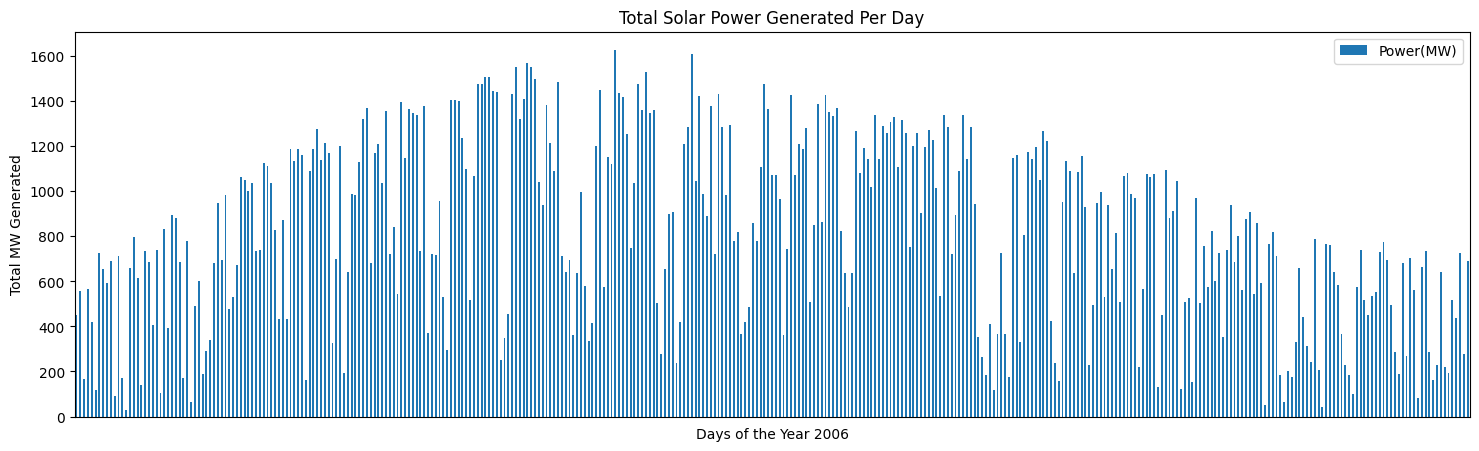

In [10]:
days_df = df.groupby('Date').sum('Power(MW)').reset_index()
days_df.plot(kind='bar', x='Date', y='Power(MW)', xlabel='Days of the Year 2006', ylabel='Total MW Generated')

plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().set_title('Total Solar Power Generated Per Day')
plt.gcf().set_size_inches(18, 5)


Above, we can see a sort of bell curve distribution among the high values, peaking in the summer months, with plenty of much lower days interspersed. To create a predictive model for total power generated per day, let's load up a separate CSV file containing key weather features for the corresponding time and place: the year 2006 in The Bronx, NY. 

In [28]:
features_df = pd.read_csv('/Users/tareq/solar_panel_model/Bronx_Weather_Features_2006.csv', header=0)

print(features_df.head())


         Date  TempF  HrsDaylight  Humidity  Precipitation
0  2006-01-01   37.7         9.00      75.2           0.00
1  2006-01-02   42.2         9.04      73.7           0.58
2  2006-01-03   37.9         9.08      85.2           0.89
3  2006-01-04   34.3         9.12      70.4           0.00
4  2006-01-05   42.5         9.16      76.5           0.07


Let's plot these four weather features to get a visual sense of how they each vary over the year before completing the regression.

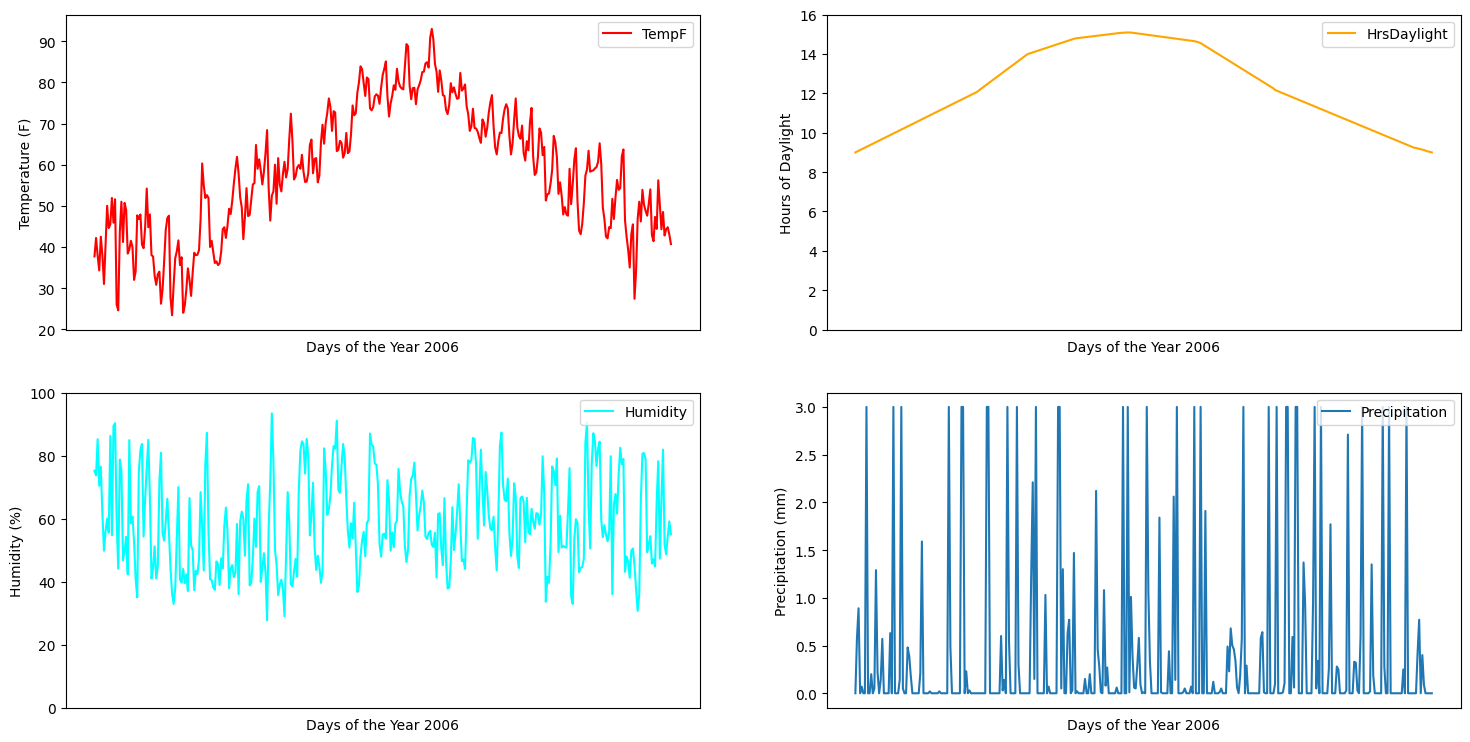

In [53]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 9))

features_df.plot(kind='line', x='Date', y='TempF', ax=axs[0, 0], color='red')
axs[0, 0].set_xlabel('Days of the Year 2006')
axs[0, 0].set_ylabel('Temperature (F)')
axs[0, 0].xaxis.set_major_locator(plt.NullLocator())

features_df.plot(kind='line', x='Date', y='HrsDaylight', ax=axs[0, 1], color='orange')
axs[0, 1].set_xlabel('Days of the Year 2006')
axs[0, 1].set_ylabel('Hours of Daylight')
axs[0, 1].set_ylim(0, 16)
axs[0, 1].xaxis.set_major_locator(plt.NullLocator())

features_df.plot(kind='line', x='Date', y='Humidity', ax=axs[1, 0], color='cyan')
axs[1, 0].set_xlabel('Days of the Year 2006')
axs[1, 0].set_ylabel('Humidity (%)')
axs[1, 0].set_ylim(0, 100)
axs[1, 0].legend(loc='upper right')
axs[1, 0].xaxis.set_major_locator(plt.NullLocator())

features_df.plot(kind='line', x='Date', y='Precipitation', ax=axs[1, 1])
axs[1, 1].set_xlabel('Days of the Year 2006')
axs[1, 1].set_ylabel('Precipitation (mm)')
axs[1, 1].legend(loc='upper right')
axs[1, 1].xaxis.set_major_locator(plt.NullLocator())

Let's merge these two dataframes on Date (2006-01-01 to 2006-12-31) so we can draw our dependent and independent variables from the same place. Even though TempF (Fahrenheit) is not measured in an absolute unit like degrees Kelvin, linear regression is fortunately agnostic to scale and offset. (I even tried both!)

In [54]:
merge_df = days_df.merge(features_df,
                  on ='Date', how='right')
merge_df['Power(MW)'] = days_df['Power(MW)']

print(merge_df.head())

         Date  Power(MW)  TempF  HrsDaylight  Humidity  Precipitation
0  2006-01-01      451.3   37.7         9.00      75.2           0.00
1  2006-01-02      557.7   42.2         9.04      73.7           0.58
2  2006-01-03      164.7   37.9         9.08      85.2           0.89
3  2006-01-04      567.5   34.3         9.12      70.4           0.00
4  2006-01-05      418.6   42.5         9.16      76.5           0.07


To train a linear regression model, we can now set the independent variables (X) as every column except Date and Power(MW), and set the dependent variable (y) to the column Power(MW) only. We can separate out a test set from our majority of training data to run predictions on later.

In [55]:
X = merge_df.drop('Power(MW)',axis=1)
X = X.drop('Date',axis=1)
y = merge_df['Power(MW)'].to_numpy().reshape(-1, 1)

# split train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=40)

# fit the LinearRegression model on the train set
model = LinearRegression()
model.fit(X_train, y_train)

# display resulting coefficients
coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(model.coef_))], axis=1, ignore_index=True)
coefficients.rename(columns={0: 'Feature', 1: 'Coefficient'}, inplace=True)

print(coefficients)


         Feature  Coefficient
0          TempF     0.891210
1    HrsDaylight   102.143783
2       Humidity   -15.850044
3  Precipitation   -49.055223


As we might expect from these coefficients for each feature, TempF (temperature in Fahrenheit) and HrsDaylight are positively correlated with the amount of solar power produced, while Humidity and Precipitation are negatively correlated. Now that training is complete, we can run predictions on the test set based on the weather conditions, then compare the model's predictions to the actual values in Difference and % Error.

In [56]:
predictions = model.predict(X_test)

predict_df = pd.DataFrame(y_test)
predict_df.columns = ['ActualValue(MW)']

predict_df['PredValue(MW)'] = predictions
predict_df['PredValue(MW)'] = predict_df['PredValue(MW)'].apply(lambda value:round(value, 1))

predict_df['Difference'] = predictions - y_test
predict_df['Difference'] = predict_df['Difference'].apply(lambda value:round(value, 1))

predict_df['% Error'] = round(100*(predict_df['Difference']/predict_df['ActualValue(MW)']), 2)

print(predict_df)
print('\n')
print('Average Difference:')
print(round(predict_df['Difference'].sum()/36, 1))

    ActualValue(MW)  PredValue(MW)  Difference  % Error
0            1286.4         1084.0      -202.4   -15.73
1             881.9         1015.7       133.8    15.17
2             812.3          749.3       -63.0    -7.76
3             994.3          673.0      -321.3   -32.31
4             494.2          555.0        60.8    12.30
5             689.9          569.6      -120.3   -17.44
6             367.5          633.3       265.8    72.33
7            1198.4         1015.8      -182.6   -15.24
8             860.4          845.0       -15.4    -1.79
9            1435.2         1308.2      -127.0    -8.85
10           1186.6          865.2      -321.4   -27.09
11           1185.0         1122.5       -62.5    -5.27
12           1186.9          927.1      -259.8   -21.89
13            185.5          183.0        -2.5    -1.35
14            786.8          697.5       -89.3   -11.35
15            116.0          523.1       407.1   350.95
16            567.5          301.3      -266.2  

The negative Average Difference value observed indicates that this linear regression model generally tends to underestimate how much solar power will be generated. Dates with high solar power generated are particularly susceptible to underestimating, while days with very low solar power generated may be overestimated; the predictions often err towards the middle. 

Let's merge the Date column back into our predictions and visualize the model's overall performance on the random sample of test data. Not bad at all, considering these solar predictions are exclusively based on weather data!

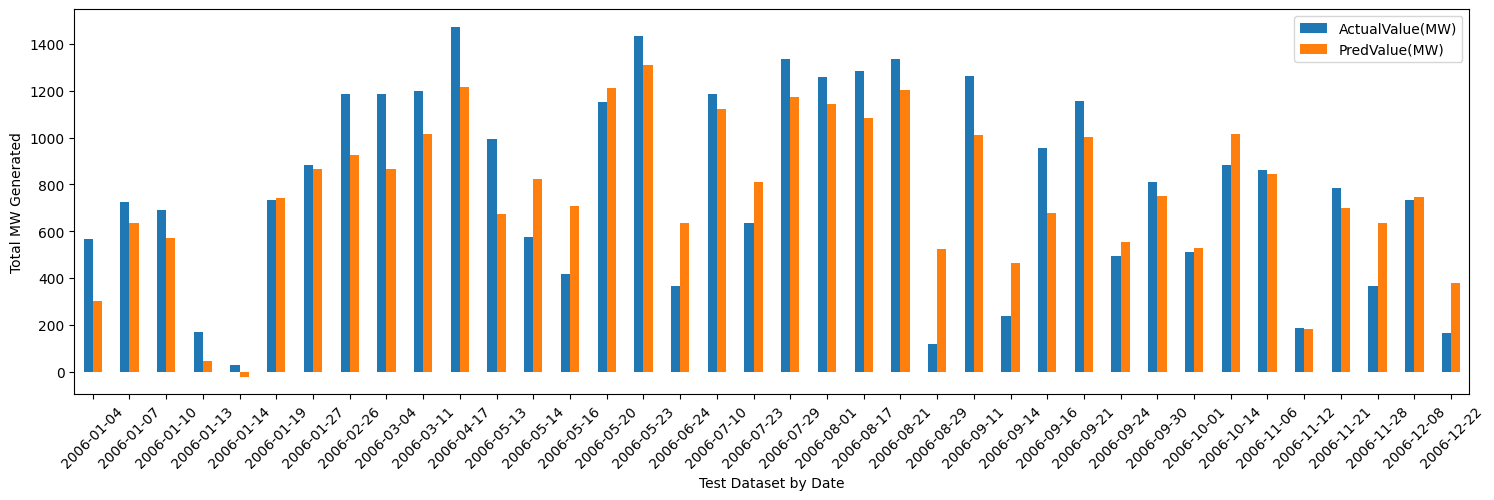

In [62]:
merge_test_df = predict_df.merge(merge_df,
                  left_on='ActualValue(MW)', right_on='Power(MW)', how='left')
merge_test_df.sort_values(by=['Date'], inplace=True)
merge_test_df = merge_test_df.reset_index(drop=True)

merge_test_df.plot(x='Date', y=['ActualValue(MW)', 'PredValue(MW)'], xlabel='Test Dataset by Date', ylabel='Total MW Generated', kind="bar", rot=45)
plt.gcf().set_size_inches(18, 5)